In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [50]:
%matplotlib inline

## Loading Data Files

In [3]:
anki_path = 'data/anki/' #replace this with the path to where anki .txts are stored
anki_path

'data/anki/'

### Anki File preparations

Since the Anki data includes attribution, I made a small shell one liner to run to remove attribution before running the following code:

`cat eng-ita.txt | sed 's/CC-BY.*//' > eng-ita.txt`

This pipes in the output of the `cat` command into `sed`, which then replaces all text after (and including) "CC-BY", then pipes that into a new file with the same name.

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [28]:
def readLangs(lang1, lang2, reverse=False):

    # Read the file and split into lines
    file_path = anki_path+lang1+"-"+lang2+".txt"
    print("Reading lines from", file_path)

    lines = open(file_path, encoding='utf-8').read().strip().split('\n')

    #remove trailing tab
    lines = [l.strip() for l in lines]
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


In [29]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [30]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


In [31]:
input_lang, output_lang, pairs = prepareData('eng', 'ita', True)
print(random.choice(pairs))

Reading lines from data/anki/eng-ita.txt
Read 341554 sentence pairs
Trimmed to 31079 sentence pairs
Counting words...
Counted words:
ita 5260
eng 3091
['e ovviamente ubriaca .', 'you re obviously drunk .']


## Seq2Seq Model

In [32]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [33]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [34]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

In [35]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [36]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [37]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [38]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [39]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

In [40]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [41]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [42]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)




# Training and Evaluation

2m 4s (- 29m 6s) (5000 6%) 2.8054
4m 3s (- 26m 23s) (10000 13%) 2.1141
5m 59s (- 23m 58s) (15000 20%) 1.8097
7m 59s (- 21m 57s) (20000 26%) 1.5260
10m 0s (- 20m 1s) (25000 33%) 1.3039
11m 54s (- 17m 51s) (30000 40%) 1.1699
13m 54s (- 15m 53s) (35000 46%) 1.0302
15m 54s (- 13m 55s) (40000 53%) 0.9173
17m 55s (- 11m 56s) (45000 60%) 0.8213
19m 56s (- 9m 58s) (50000 66%) 0.7479
21m 58s (- 7m 59s) (55000 73%) 0.6558
24m 0s (- 6m 0s) (60000 80%) 0.6333
25m 59s (- 3m 59s) (65000 86%) 0.5699
28m 0s (- 2m 0s) (70000 93%) 0.5130
29m 58s (- 0m 0s) (75000 100%) 0.4761


<Figure size 432x288 with 0 Axes>

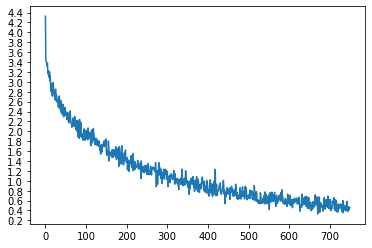

In [52]:
hidden_size = 380
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [53]:
evaluateRandomly(encoder1, attn_decoder1)

> non sono bravo a cantare .
= i m not good at singing .
< i m not good at drawing . <EOS>

> e troppo vecchia per te .
= she s too old for you .
< you re too old for you . <EOS>

> voi mi state ignorando .
= you re ignoring me .
< you re ignoring me . <EOS>

> e molto esigente quando si tratta di cibo .
= she is particular about food .
< you re obviously kind of food . <EOS>

> io sono il vostro capo .
= i m your boss .
< i m your boss . <EOS>

> lei e gia tornata .
= she is already back .
< she is already back . <EOS>

> tu sei una sensitiva .
= you re psychic .
< you re psychic . <EOS>

> vengo da boston .
= i m from boston .
< i m from boston . <EOS>

> stai scherzando giusto ?
= you re joking right ?
< you re kidding right ? <EOS>

> sta indossando degli occhiali da sole .
= she s wearing sunglasses .
< he s wearing wearing <EOS>



### Evaluate and Show Attention

input = sono convinta della vostra innocenza .
output = i am convinced of your innocence . <EOS>


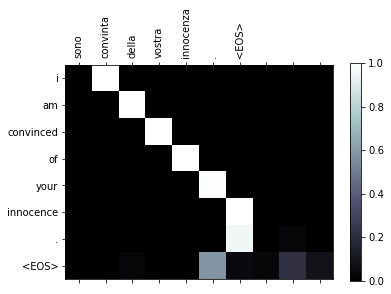

In [55]:
evaluateAndShowAttention("sono convinta della vostra innocenza .")

### Question 2 (Model refinement --- 10 points):  Refine your model by adding either (a) more layers or (b) more hidden units. Compare the training time and results. Run at least one additional experiment. 

I first chose to refine the model by upping the hidden units to 512. Here's that output:

```
1m 56s (- 27m 10s) (5000 6%) 2.7571
3m 55s (- 25m 33s) (10000 13%) 2.0869
5m 51s (- 23m 24s) (15000 20%) 1.6780
7m 48s (- 21m 29s) (20000 26%) 1.4612
9m 47s (- 19m 35s) (25000 33%) 1.2316
11m 47s (- 17m 41s) (30000 40%) 1.0800
13m 47s (- 15m 46s) (35000 46%) 0.9281
15m 47s (- 13m 48s) (40000 53%) 0.7990
17m 45s (- 11m 50s) (45000 60%) 0.7241
19m 44s (- 9m 52s) (50000 66%) 0.6719
21m 45s (- 7m 54s) (55000 73%) 0.5921
23m 46s (- 5m 56s) (60000 80%) 0.5551
25m 45s (- 3m 57s) (65000 86%) 0.5021
27m 47s (- 1m 59s) (70000 93%) 0.4470
29m 45s (- 0m 0s) (75000 100%) 0.4134
```

Having a loss of 0.4134 at the end of training is very good!

I wanted to see if having the hidden units at 380 units would offer a smaller improvement due to overfitting, or only be slightly worse. Here's that output:

```
2m 4s (- 29m 6s) (5000 6%) 2.8054
4m 3s (- 26m 23s) (10000 13%) 2.1141
5m 59s (- 23m 58s) (15000 20%) 1.8097
7m 59s (- 21m 57s) (20000 26%) 1.5260
10m 0s (- 20m 1s) (25000 33%) 1.3039
11m 54s (- 17m 51s) (30000 40%) 1.1699
13m 54s (- 15m 53s) (35000 46%) 1.0302
15m 54s (- 13m 55s) (40000 53%) 0.9173
17m 55s (- 11m 56s) (45000 60%) 0.8213
19m 56s (- 9m 58s) (50000 66%) 0.7479
21m 58s (- 7m 59s) (55000 73%) 0.6558
24m 0s (- 6m 0s) (60000 80%) 0.6333
25m 59s (- 3m 59s) (65000 86%) 0.5699
28m 0s (- 2m 0s) (70000 93%) 0.5130
29m 58s (- 0m 0s) (75000 100%) 0.4761
```

We see that there's really not much of a difference, but 0.4134 is better than 0.4761. Their training time is very similar, with only 13 seconds of difference, favoring the 512 hidden units.

### Question 3*** (Model diagnosis -- 5 points):  What do you observe based on your implementation for Question 2? Write at least 100 words.


I observe that higher hidden units is better, but of course, only to a point (overfitting is still a thing we must be vigilant about) and that my model trains for 30 minutes for both 256, 380, and 512 hidden units. I suspect this to be due to the fact that PyTorch is using CUDA to parallelize the computations, thus making it a scale a lot better. 

In terms of model performance, the difference between the 512 hidden units and 380 hidden units is nigh negligible for this size of dataset. I ran the 380 hidden unit model in another jupyter notebook using French, since I speak a little bit of it, to see if the semantics make sense. My hypothesis was that the semantics from the attention model (this one) would be better than the model we did that was just Seq2Seq without attention. I was correct, in that the semantics were far better. Both the grammar as well as meaning were better when it concerned pronouns such as "tu" or "je", which I will assume holds with the Italian model, as it was trained with the exact same parameters and the datasets are of the same quality.